In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.tsa.stattools as smt
from scipy.optimize import curve_fit

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from statsmodels.tsa.api import VAR
from statsmodels.tsa.tsatools import detrend

### Replication of single-run plots

In [2]:
df_1 = pd.read_csv('validation_samples/valoutput_2.csv')

In [3]:
T = range(len(df_1.GDP))

In [4]:
def indexnumber(ts):
    return 100 * ts / ts[0]

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [6]:
# Set parameters for bandpass filters
bk_low = 18
bk_high = 96
bk_K = 36

* SF1 Endogenous and self-sustained growth of output, with persistent fluctuations.
* SF4 Aggregate consumption is less volatile than GDP, and aggregate investments are
more volatile than GDP.
* SF6 Synchronization of the business cycle and emission dynamics.

(Partial) replication of Dosi (2010) fig 1 and 2, Lamperti et al (2018) fig 2 and 8

In [7]:
real_GDP_1 = df_1.GDP.iloc[300:].to_numpy() / df_1.prices.iloc[300:].to_numpy()
real_C = df_1.C.iloc[300:].to_numpy() / df_1.prices.iloc[300:].to_numpy()
real_I = df_1.I.iloc[300:].to_numpy() / df_1.prices.iloc[300:].to_numpy()

In [8]:
x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP_1), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(real_C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(real_I), bk_low, bk_high, bk_K)

Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.Em.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_1.EnDem.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)

T_filter = range(len(gdp_filtered))

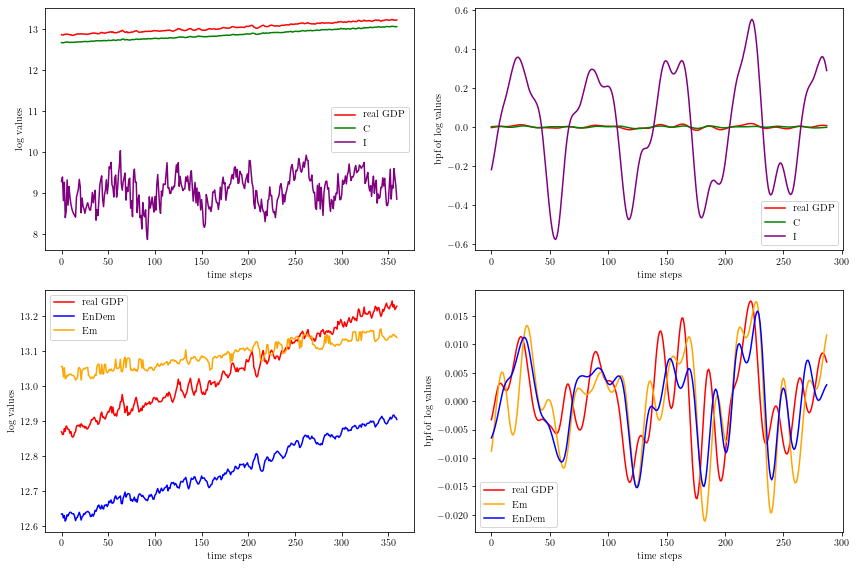

In [9]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12,8))

ax1.plot(np.log(real_GDP_1), label='real GDP', color='red')
ax1.plot(np.log(real_C), label='C', color='green')
ax1.plot(np.log(real_I), label='I', color='purple')
ax1.set_ylabel('log values')
ax1.set_xlabel('time steps')
ax1.legend()

ax2.plot(gdp_filtered, label='real GDP', color='red')
ax2.plot(C_filtered, label='C', color='green')
ax2.plot(I_filtered, label='I', color='purple')
ax2.set_xlabel('time steps')
ax2.set_ylabel('bpf of log values')
ax2.legend()

ax3.plot(np.log(real_GDP_1), label='real GDP', color='red')
ax3.plot(np.log(df_1.EnDem.iloc[300:].to_numpy()), label='EnDem', color='blue')
ax3.plot(np.log(df_1.Em.iloc[300:].to_numpy()), label='Em', color='orange')
ax3.set_xlabel('time steps')
ax3.set_ylabel('log values')
ax3.legend()

ax4.plot(gdp_filtered, label='real GDP', color='red')
ax4.plot(Em_filtered, label='Em', color='orange')
ax4.plot(EnDem_filtered, label='EnDem', color='blue')
ax4.set_xlabel('time steps')
ax4.set_ylabel('bpf of log values')
ax4.legend()

plt.tight_layout()
plt.show()

(Partial) replication of Lamperti et al (2018) fig 7

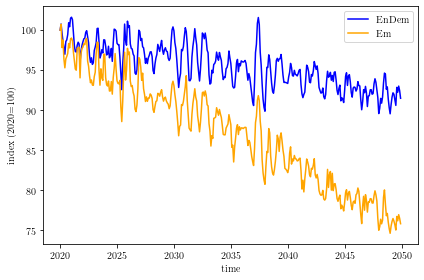

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(indexnumber(df_1.EnDem.iloc[300:].to_numpy() / real_GDP_1), c='blue', label='EnDem')
ax.set_xlabel('time')
ax.set_ylabel('index (2020=100)')
ax.set_xticks(x, years)

ax.plot(indexnumber(df_1.Em.iloc[300:].to_numpy() / real_GDP_1), c='orange', label='Em')
ax.set_xlabel('time')
ax.set_xticks(x, years)

ax.legend()

plt.tight_layout()
plt.show()

## Firm characteristics

In [11]:
df_firms = pd.read_csv('validation_samples/valfirmdata_2.csv')
df_firms.head()

,t,agecp_2501,agecp_2502,agecp_2503,agecp_2504,agecp_2505,agecp_2506,agecp_2507,agecp_2508,agecp_2509,...,Kcp_2691,Kcp_2692,Kcp_2693,Kcp_2694,Kcp_2695,Kcp_2696,Kcp_2697,Kcp_2698,Kcp_2699,Kcp_2700
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2400.0,2400.000000,2340.000000,2340.000000,2400.0,2400.000000,2400.0,2340.000000,2400.000000,2400.000000
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2400.0,2339.749023,2340.000000,2340.000000,2400.0,2400.000000,2340.0,2358.437205,2400.000000,2340.000000
2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2400.0,2339.749023,2340.000000,2353.971973,2340.0,2400.000000,2340.0,2358.437205,2340.000000,2353.971973
3,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2340.0,2339.749023,2280.000000,2293.971973,2280.0,2417.426719,2340.0,2358.437205,2298.681748,2353.971973
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,2340.0,2339.749023,2219.347797,2233.971973,2220.0,2417.426719,2280.0,2358.437205,2238.681748,2233.971973


In [12]:
start_t = 300

In [13]:
def mean_std_firmdata(colstart):
    all_ts = [col for col in df_firms if col.startswith(colstart)]
    ts_mean = df_firms[all_ts].iloc[start_t:].mean(axis=1)
    ts_std = df_firms[all_ts].iloc[start_t:].std(axis=1)
    return ts_mean, ts_std

(Partial) replication of Dosi (2010) fig 5

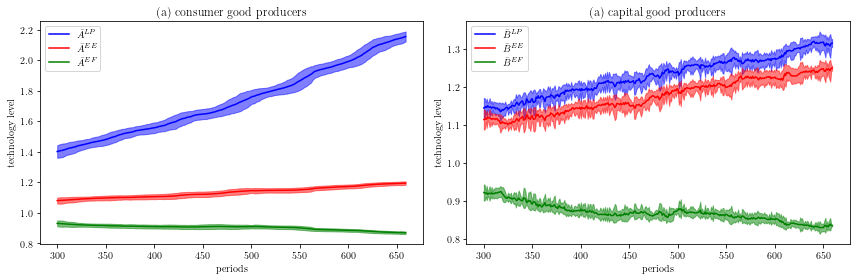

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

for colstart, color, label in zip(['LPcp', 'EEcp', 'EFcp'], ['blue', 'red', 'green'], ['$\\bar{A}^{LP}$', '$\\bar{A}^{EE}$', '$\\bar{A}^{EF}$']):
    ts_mean, ts_std = mean_std_firmdata(colstart)
    ax1.plot(ts_mean, color=color, label=label)
    ax1.fill_between(np.arange(300,660), ts_mean + 2 * ts_std, ts_mean - 2 * ts_std, alpha=0.5, color=color)

ax1.legend(loc='upper left')
ax1.set_xlabel('periods')
ax1.set_ylabel('technology level')
ax1.set_title('(a) consumer good producers')

for colstart, color, label in zip(['LPkp', 'EEkp', 'EFkp'], ['blue', 'red', 'green'], ['$\\bar{B}^{LP}$', '$\\bar{B}^{EE}$', '$\\bar{B}^{EF}$']):
    ts_mean, ts_std = mean_std_firmdata(colstart)
    ax2.plot(ts_mean, color=color, label=label)
    ax2.fill_between(np.arange(300,660), ts_mean + 2 * ts_std, ts_mean - 2 * ts_std, alpha=0.5, color=color)

ax2.legend(loc='upper left')
ax2.set_xlabel('periods')
ax2.set_ylabel('technology level')
ax2.set_title('(a) capital good producers')

plt.tight_layout()
plt.show()
# plt.plot()

(Partial) replication of Dosi (2010) fig 6

In [15]:
I_cols = [col for col in df_firms if col.startswith("Icp")]
K_cols = [col for col in df_firms if col.startswith("Kcp")]
I_ratio = df_firms[I_cols].to_numpy() / df_firms[K_cols].to_numpy()

In [16]:
# Make investment ratio's quarterly
I_month = df_firms[I_cols].to_numpy()
K_month = df_firms[K_cols].to_numpy()

I_ratio_quarterly = np.array([np.sum(I_month[i:i+3, :] / K_month[i:i+3, :], axis=0) for i in np.arange(0, 660, step=3)])

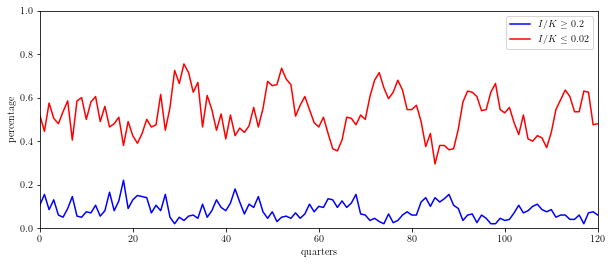

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(np.sum(I_ratio_quarterly >= 0.2, axis=1) / 200, label='$I/K \geq 0.2$', color='blue')
plt.plot(np.sum(I_ratio_quarterly <= 0.02, axis=1) / 200, label='$I/K \leq 0.02$', color='red')

plt.xlim(99, 219)
plt.ylim(0, 1)
plt.xticks(np.arange(99, 220, step=20), np.arange(0, 121, step=20))
plt.xlabel('quarters')
plt.ylabel('percentage')
plt.legend()

plt.show()

In [18]:
S_cp_cols = [col for col in df_firms if col.startswith('Scp')]
S_cp_month = df_firms[S_cp_cols].to_numpy()

# Pool data to be yearly
S_cp_year = np.array([np.sum(S_cp_month[i:i+12, :], axis=0) for i in np.arange(0, 660, step=12)])
S_cp_year_mean = np.mean(S_cp_year, axis=1)
S_cp_year_norm = np.transpose(np.transpose(S_cp_year) / S_cp_year_mean)
S_cp_year_norm = np.sort(S_cp_year_norm[-30:].flatten())[::-1]


In [19]:
s, loc, scale = stats.lognorm.fit(S_cp_year_norm)

S_fitted = stats.lognorm.rvs(s, loc, scale, size=len(S_cp_year_norm))
S_fitted = np.sort(S_fitted)[::-1]

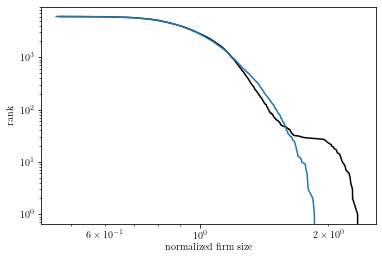

In [20]:
x = np.linspace(min(S_cp_year_norm), max(S_cp_year_norm), 1000)
plt.plot(S_cp_year_norm, range(len(S_cp_year_norm)), c='black')
plt.plot(S_fitted, range(len(S_fitted)))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('normalized firm size')
plt.ylabel('rank')
plt.show()

## Income and wealth distributions

In [21]:
def powerlaw(x, alpha, beta):
    return beta * x ** (-1 - alpha)

In [22]:
df_I_W = pd.read_csv('../result_data/final_income_dists.csv')

start_60 = round(20/100 * 2500)
end_60 = round(80/100 * 2500)

I_sorted = np.sort(df_I_W.all_I.to_numpy())
I_share = sum(I_sorted[start_60:end_60]) / sum(I_sorted)
print("I share:", I_share)

W_sorted = np.sort(df_I_W.all_W.to_numpy())
W_share = sum(W_sorted[start_60:end_60]) / sum(W_sorted)
print("W share:", W_share)

I share: 0.5705851157313737
W share: 0.5440598302954237


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


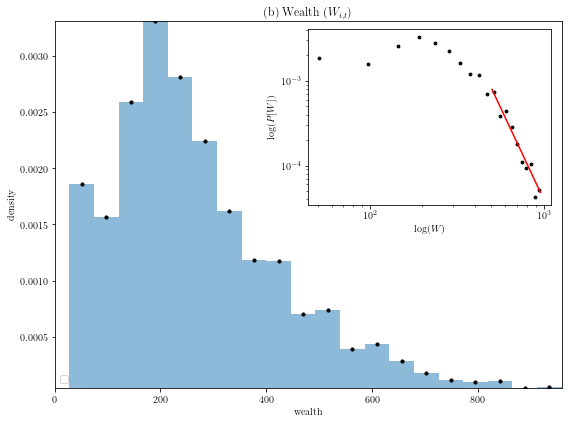

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

dens, bins, _ = ax.hist(df_I_W.all_W, bins=20, density=True, alpha=0.5)
bins1 = bins[:-1]
bins2 = bins[1:]
bins = np.mean([bins1, bins2], axis=0)

idx = np.where(dens != 0)[0][10:]
[alpha_hat, beta_hat], [alpha_cov, beta_cov] = curve_fit(powerlaw, bins[idx], dens[idx])
start_W = 2250

ax.scatter(bins, dens, s=10, color='black')
ax.set_title('(b) Wealth ($W_{i,t}$)')
ax.set_xlim(0, max(df_I_W.all_W))
ax.set_ylim(min(dens), max(dens))

ax.set_ylabel('density')
ax.set_xlabel('wealth')
ax.legend(loc='lower left')

start_W = 2250

s, loc, scale = stats.lognorm.fit(W_sorted[700:start_W])

axins = ax.inset_axes([0.5, 0.5, 0.48, 0.48])
axins.plot(W_sorted[start_W:], powerlaw(W_sorted[start_W:], alpha_hat, beta_hat), color='red')
# axins.plot(W_sorted[700:start_W], stats.lognorm.pdf(W_sorted[700:start_W], s, loc, scale), color='red')
# axins.plot(W_sorted[2250:], stats.powerlaw.pdf(W_sorted[2250:], a, loc, scale))
axins.set_yscale('log')
axins.set_xscale('log')
axins.set_ylabel('$\\log (P[W])$')
axins.set_xlabel('$\\log (W)$')
axins.scatter(bins, dens, s=8, color='black')

plt.tight_layout()
plt.show()

## Aggregate results

In [24]:
# Open all validation files

def filepath(i):
    return f'validation_samples/valoutput_{i}.csv'

n_MC = 100

df_list = []
for MC_i in range(1, n_MC + 1):
    df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])
df = pd.concat(df_list)

* SF2 The distribution of GDP growth rates is fat-tailed.

(Partial) reproduction of Dosi (2017) fig 2

In [25]:
print(np.mean(df.GDP_growth))

0.32254900967948535


KurtosistestResult(statistic=13.038252360117374, pvalue=7.41369565247801e-39)


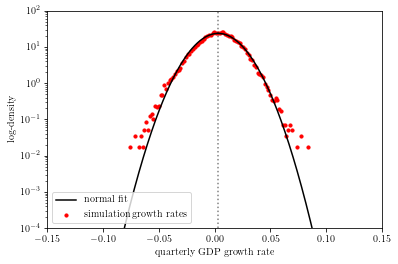

In [26]:
plt.figure(figsize=(6,4))

data = df.GDP_growth / 100
mean_GDP_growth = np.mean(data)
x = np.linspace(-0.2, 0.2, 1000)
dens, bins, _ = plt.hist(data, bins=100, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]

print(stats.kurtosistest(data))

bins = np.mean([bins1, bins2], axis=0)
plt.plot(x, best_fit_line, color='black', label='normal fit')
plt.scatter(bins, dens, s=10, c='red', label='simulation growth rates')
plt.legend(loc='lower left')
plt.xlabel('quarterly GDP growth rate')
plt.ylabel('log-density')
plt.xlim(-0.15, 0.15)
plt.ylim(10e-5, 100)
plt.axvline(mean_GDP_growth, linestyle='dotted', alpha=0.5, c='black')

plt.yscale('log')
plt.show()

In [27]:
# U_filtered = sm.tsa.filters.bkfilter(np.log(df.U), bk_low, bk_high, bk_K)
# LIS_filtered = sm.tsa.filters.bkfilter(df.LIS, bk_low, bk_high, bk_K)
# C_filtered = sm.tsa.filters.bkfilter(np.log(df.C / df.prices), bk_low, bk_high, bk_K)
# I_filtered = sm.tsa.filters.bkfilter(np.log(df.I / df.prices), bk_low, bk_high, bk_K)
# Em_filtered = sm.tsa.filters.bkfilter(np.log(df.Em), bk_low, bk_high, bk_K)
# EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df.EnDem), bk_low, bk_high, bk_K)
# TotDebt_filtered = sm.tsa.filters.bkfilter(np.log(df.TotDebt / df.prices), bk_low, bk_high, bk_K)
# prices_filtered = sm.tsa.filters.bkfilter(np.log(df.prices), bk_low, bk_high, bk_K)

* SF3 The duration of recessions is exponentially distributed.

(Partial) reproduction of Dosi (2017) fig 3

In [28]:
# Count recession periods
durations = []

recession = False
duration = 0

for g in df.GDP_growth:

    if g < 0:
        if recession:
            duration += 1
        else:
            recession = True
            duration = 1
        
    elif g > 0 and recession:
        recession = False
        durations += [duration]

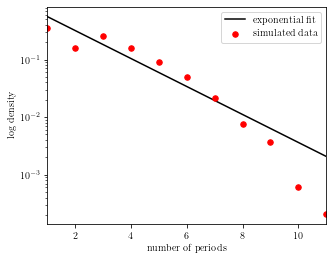

In [29]:
plt.figure(figsize=(5,4))

dens, bins, _ = plt.hist(durations, density=True, bins=max(durations), alpha=0)

loc, scale = stats.expon.fit(durations)
x = np.linspace(1, max(bins), 100)

plt.plot(x, stats.expon.pdf(x, loc, scale), label='exponential fit', c='black')
plt.scatter(np.arange(1, max(bins) + 1), dens, label='simulated data', c='red', s=30, zorder=2)
plt.xlim(1, max(bins))
plt.yscale('log')
plt.xlabel('number of periods')
plt.ylabel('log density')
plt.legend()
plt.show()

* SF5 Cross-correlations of macro-variables
    * Consumption, net investments, changes in inventories, productivity R&D investments, energy demand and nominal wages are pro-cyclical.
    * Unemployment and markups are counter-cyclical.
    * Real wages are a-cyclical.

* SF6 Synchronization of the business cycle and emission dynamics.

(Partial) replication of figure 4 in Lamperti et al (2018)

In [30]:
def compute_correlations(indicator, apply_bk=False, make_real=False, min_lag=-3, max_lag=3):

    all_corr = []

    for df_part in df_list[0:1]:

        # Apply filter
        real_GDP =  df_part.GDP.to_numpy() / df_part.prices.to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)

        # Prepare data
        ind_data = df_part[indicator].to_numpy()
        
        if make_real:
            ind_data = ind_data / df_part.prices.to_numpy()

        if apply_bk:
            ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)

        ccf_back = smt.ccf(ind_data[::-1], gdp_filtered[::-1])[1:-min_lag+1][::-1]
        ccf_forw = smt.ccf(ind_data, gdp_filtered)[:max_lag+1]
        ccf = np.concatenate((ccf_back, ccf_forw))

        all_corr.append([ccf])

    avg_corr = np.transpose(np.mean(np.array(all_corr), axis=0))

    return avg_corr

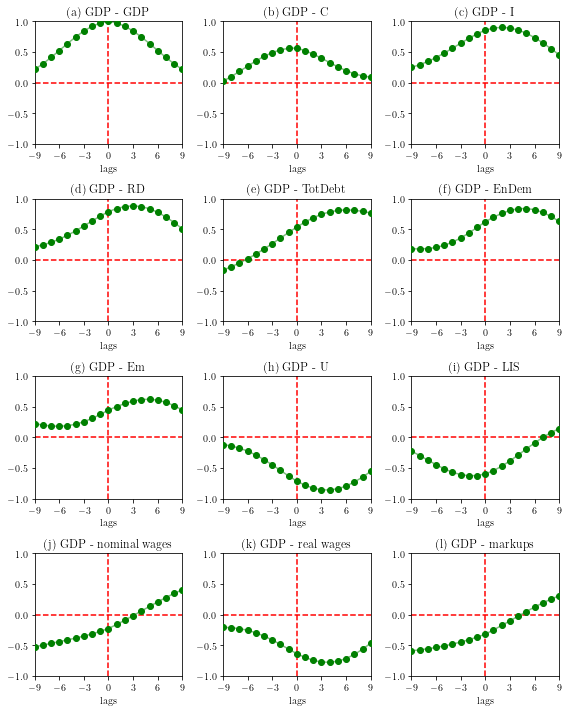

In [31]:
lags = 9
min_lag = -lags
max_lag = lags

indicators = ['GDP', 'C', 'I', 'RD', 'TotDebt', 'EnDem', 'Em', 
              'U', 'LIS', 'wages', 'real wages', 'markups']
lags = np.arange(min_lag, max_lag + 1)

fig, axes = plt.subplots(4, 3, figsize=(8, 10))

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

    fig_nr = chr(i + 97)

    title = indicator

    apply_bk = True
    make_real = True
    if indicator in ['markups', 'U', 'EnDem', 'Em', 'LIS', 'wages']:
        make_real=False
        if indicator == 'wages':
            title = 'nominal wages'

    if indicator == 'real wages':
        indicator = 'wages'

    all_r = compute_correlations(indicator, apply_bk=apply_bk, make_real=make_real,
                                        min_lag=min_lag, max_lag=max_lag)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='red')
    ax.vlines(0, -1., 1, linestyle='dashed', color='red')

    ax.scatter(lags, all_r, color='green', zorder=10)
    ax.plot(lags, all_r, alpha=0.5, color='green', zorder=9)

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) GDP - {title}')
    ax.set_xlabel('lags')

plt.tight_layout()
plt.savefig('../../plotting/validation/cross_correlations.pdf', bbox_inches='tight')
plt.show()

In [32]:
filtered_series ={
    'GDP': sm.tsa.filters.bkfilter(np.log(df.GDP / df.prices), bk_low, bk_high, bk_K),
    '$\\hat{\\mu}$': sm.tsa.filters.bkfilter(df.markups, bk_low, bk_high, bk_K),
    'I': I_filtered.to_numpy(),
    'C': C_filtered.to_numpy(),
    'U': U_filtered.to_numpy(),
    'LIS': LIS_filtered.to_numpy(),
    'TotDebt': TotDebt_filtered.to_numpy(),
    'EnDem': EnDem_filtered.to_numpy(),
    'Em': Em_filtered.to_numpy()
}

df_filtered = pd.DataFrame(filtered_series)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

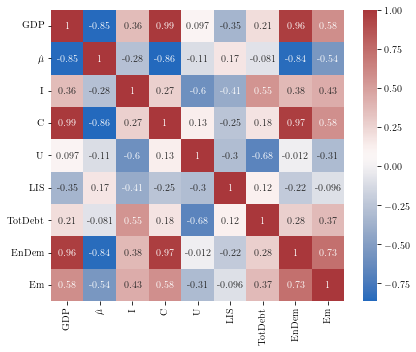

In [ ]:
import seaborn as sb
# corr = df.corr()

plt.figure(figsize=(6,5))

sb.heatmap(df_filtered.corr(), cmap="vlag", annot=True)

plt.tight_layout()
plt.show()